## Imports

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

from models.neuralnetwork.fully_connected import FullyConnected4Layers
from preprocessing.data_augmentation import extend_dataset_with_origin_reflections
from preprocessing.data_transformations import convert_coords_from_cartesian_to_spherical
from sphericalharmonics.spherical_fourier_transform import get_spherical_fourier_transform
from sphericalharmonics.spherical_fourier_transform import get_design_matrix
from lossfunctions.cross_correlation import CrossCorrelationLoss
from utils.logging import print_training_progress

from functools import partial
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd

from models.sphericaldeconvolution.spherical_deconvolution import spherical_deconvolution_fit
from models.sphericaldeconvolution.fibre_response_function import simple_fibre_response_function, diffusion_tensor_response_function
from dataloader.load_dt_simulated import load_dt_simulated_multiple_populations
from preprocessing.data_augmentation import extend_dataset_with_origin_reflections
from preprocessing.data_transformations import convert_coords_from_cartesian_to_spherical
from visualization.spherical_functions_visualisation import get_spherical_function_values_from_spherical_expansion
from sphericalharmonics.spherical_fourier_transform import get_spherical_harmonics_expansion_coefficients

# Fully connected neural network for fODF estimation

## Hyperparameters

In [2]:
input_size = 45
output_size = 45
learning_rate = 0.001
final_learning_rate = 0.0001
batch_size = 1000
num_batches = 5000
num_batches_lr_reduction = 3000
max_degree = 8

## Load dataset

In [3]:
all_dwis = np.load('./data2/planar/no_rotation/diffusion_weighted_signals.npy')
all_fODFs = np.load('./data2/planar/no_rotation/fODF_sh_coefficients.npy')
all_qhat = np.load('./data2/planar/no_rotation/gradient_orientations.npy')
all_bvals = np.load('./data2/planar/no_rotation/b_values.npy')
all_dwis_sh_coefficients = np.load("./data2/planar/no_rotation/diffusion_weighted_signals_sh_coefficients.npy")

## Pre-processing

The data is pre-processed as usual and the diffusion weighted signals are transformed to SH expansion coefficients. These coefficients are then used as the network input and the network output is the fODF coefficients.

## Define model

In [4]:
model = FullyConnected4Layers(input_size, output_size)

## Train the FCNN

In [5]:
# Loss function and optimizer
criterion = CrossCorrelationLoss(max_degree)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Data arrays
train_data = all_dwis_sh_coefficients[:60000]
train_targets = all_fODFs[:60000]
val_data = all_dwis_sh_coefficients[60000:80000]
val_targets = all_fODFs[60000:80000]
test_data = all_dwis_sh_coefficients[80000:]
test_targets = all_fODFs[80000:]

# Lists to store errors for plotting
train_errors = []
val_errors = []

# Move model to GPU
device = torch.device('mps')
model.to(device)

# Training start timestamp
start_time = time.time()

# Best validation error to select the best model
best_validation_error = None

# Training loop
for batch in range(num_batches):
    
    if(batch % 1000 == 0):
        print(batch)
    
    # Adjust learning rate
    if batch == num_batches - num_batches_lr_reduction:
        for param_group in optimizer.param_groups:
            param_group['lr'] = final_learning_rate

    indices = torch.randperm(len(train_data))[:batch_size]

    inputs = torch.FloatTensor(train_data[indices])
    targets = torch.FloatTensor(train_targets[indices])
    
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_errors.append(loss.item())

    # Calculate validation errors
    with torch.no_grad():
        val_inputs = torch.FloatTensor(val_data).to(device)
        val_target = torch.FloatTensor(val_targets).to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_target)
        val_errors.append(val_loss.item())
        
        current_validation_error = val_loss.item()
        
        if (best_validation_error is None) or (current_validation_error < best_validation_error):
            torch.save(model.state_dict(), './savedmodels/fcnn/model_weights.pth')
        
        if(batch % 100 == 0):
            pass
            print_training_progress(batch, num_batches, loss.item(), val_loss.item(), start_time)

'Batch: 4900/5000'

'Training error: 0.22785358130931854, Validation error: 0.279589980840683'

'Elapsed time: 00:01:33'

## Plot training and validation errors

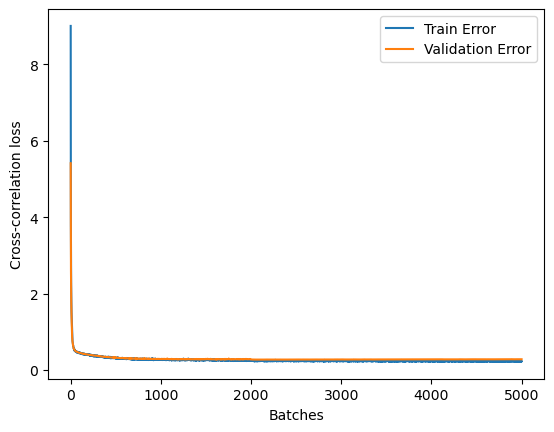

In [14]:
plt.plot(train_errors, label='Train Error')
plt.plot(val_errors, label='Validation Error')
plt.xlabel('Batches')
plt.ylabel('Cross-correlation loss')
plt.legend()
plt.show()

## Plot training and validation errors (detail)

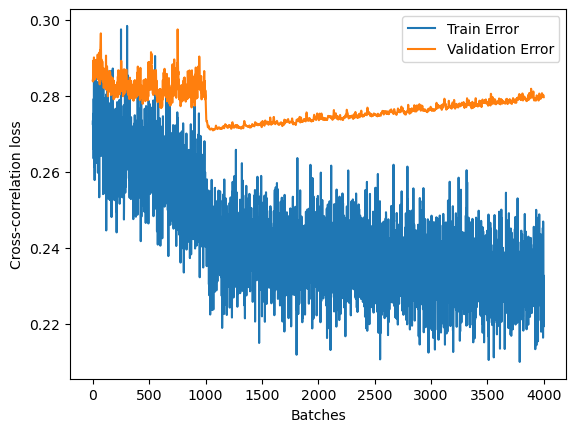

In [13]:
plt.plot(train_errors[1000:], label='Train Error')
plt.plot(val_errors[1000:], label='Validation Error')
plt.xlabel('Batches')
plt.ylabel('Cross-correlation loss')
plt.legend()
plt.show()

In [49]:
model.eval()
outputs = model(torch.FloatTensor(val_data[2:3]).to('mps'))

In [50]:
outputs

tensor([[ 2.9310e-01,  1.4529e-02,  3.3868e-03,  1.1254e-01, -7.1280e-03,
          1.1762e-01, -3.8257e-02, -6.3411e-03, -2.6180e-02,  3.8820e-04,
          5.5032e-01, -2.6163e-03, -1.1156e-01,  5.0799e-03, -7.0008e-02,
          1.8324e-02, -1.5739e-03,  2.1705e-02, -1.1035e-02,  2.3460e-02,
         -2.5878e-03,  2.8451e-01, -4.7007e-03,  1.1421e-01,  1.2508e-02,
          7.5207e-02, -3.6054e-03, -1.3280e-01,  3.3347e-02, -9.9814e-03,
         -3.4097e-02, -1.4232e-03, -4.1196e-02, -3.5907e-03, -2.2823e-02,
          2.9506e-03,  6.9812e-01,  2.2738e-03, -1.0280e-01, -4.4640e-03,
         -6.1492e-02,  7.8711e-03,  9.9119e-02,  4.9801e-03, -8.5846e-02]],
       device='mps:0', grad_fn=<LinearBackward0>)

In [51]:
outputs = torch.squeeze(outputs)
outputs = outputs.cpu().detach().numpy()

In [52]:
outputs

array([ 2.93101251e-01,  1.45286899e-02,  3.38682532e-03,  1.12538874e-01,
       -7.12804310e-03,  1.17617212e-01, -3.82573195e-02, -6.34112582e-03,
       -2.61801854e-02,  3.88195738e-04,  5.50317287e-01, -2.61631329e-03,
       -1.11558221e-01,  5.07987849e-03, -7.00081959e-02,  1.83237940e-02,
       -1.57388672e-03,  2.17046868e-02, -1.10354088e-02,  2.34602373e-02,
       -2.58782343e-03,  2.84513593e-01, -4.70072776e-03,  1.14205025e-01,
        1.25081325e-02,  7.52066001e-02, -3.60540720e-03, -1.32798702e-01,
        3.33468579e-02, -9.98136029e-03, -3.40967923e-02, -1.42322108e-03,
       -4.11959402e-02, -3.59069183e-03, -2.28228979e-02,  2.95055285e-03,
        6.98121965e-01,  2.27377750e-03, -1.02803707e-01, -4.46396321e-03,
       -6.14917800e-02,  7.87109137e-03,  9.91192982e-02,  4.98005096e-03,
       -8.58459100e-02], dtype=float32)

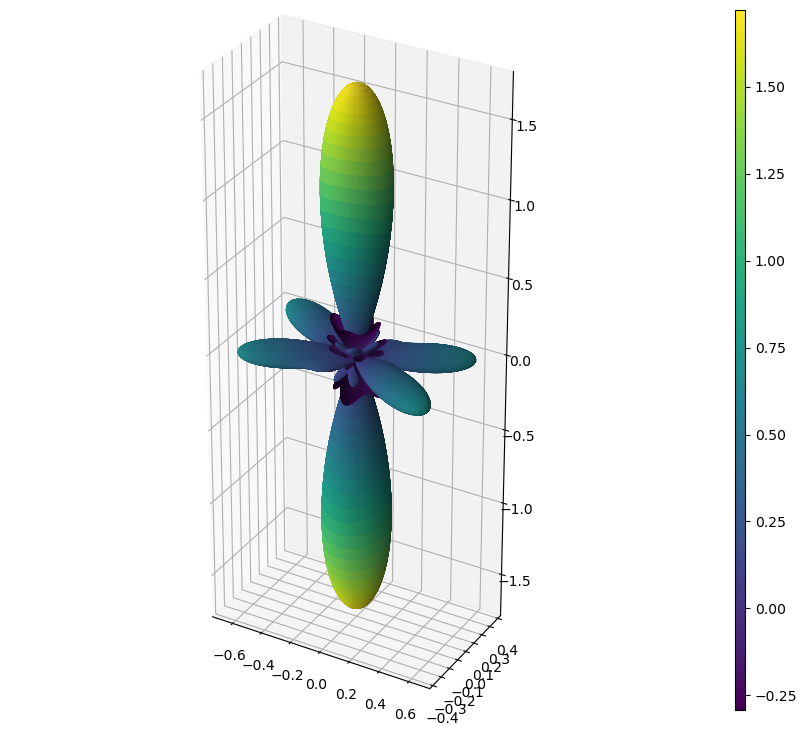

In [53]:
x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(outputs, max_degree=8,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.viridis(normalization(fcolors)), shade=True)
#ax.set_axis_off()
plt.gca().set_aspect('equal')

#ax.plot([-0.99834138,0],[-0.0575716,0],[0,0])
#ax.plot([-0.57181506,0],[-0.82038256,0],[0,0])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

In [54]:
ground_truth = val_targets[2]

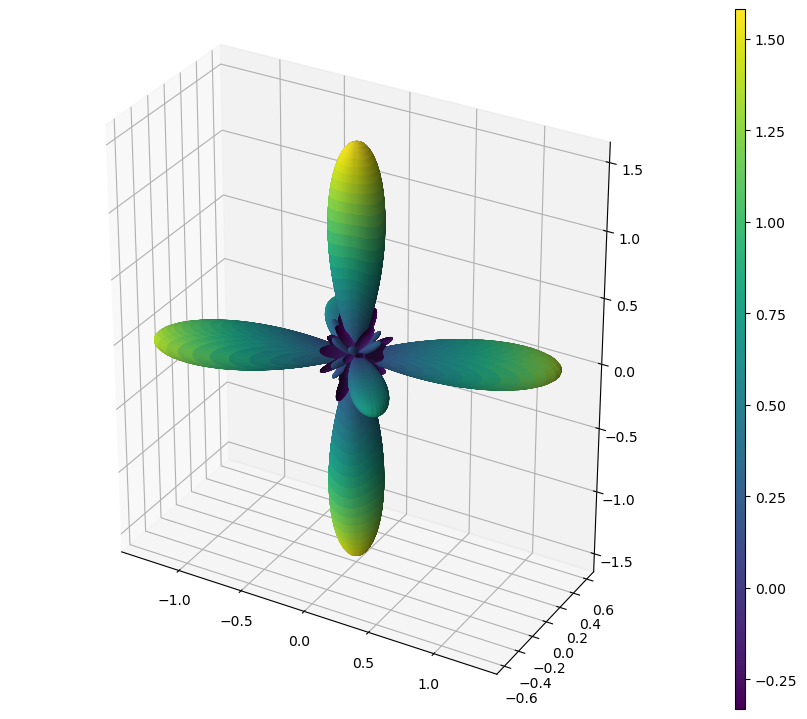

In [55]:
x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(ground_truth, max_degree=8,resolution=200,min_value=None,max_value=None, normalize=False)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.viridis(normalization(fcolors)), shade=True)
#ax.set_axis_off()
plt.gca().set_aspect('equal')

#ax.plot([-0.99834138,0],[-0.0575716,0],[0,0])
#ax.plot([-0.57181506,0],[-0.82038256,0],[0,0])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

## Load data with rotations

In [7]:
all_dwis_sh_coefficients = np.load("./data2/planar/no_rotation/diffusion_weighted_signals_sh_coefficients.npy")

In [8]:
rotated_inputs = torch.FloatTensor(all_dwis_sh_coefficients).to(device)
rotated_target = torch.FloatTensor(all_fODFs).to(device)
rotated_outputs = model(rotated_inputs)
rotated_loss = criterion(rotated_outputs, rotated_target)
rotated_loss.item()

0.27182093262672424

In [9]:
test_errors[-1]

NameError: name 'test_errors' is not defined

In [ ]:
rotated_loss.item() / test_errors[-1]